In [8]:
import os
from psutil import virtual_memory
import numpy as np
import cv2
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
from torchsummary import summary #pip install torchsummary

def see_plot(pict, color='gray', size=(4,4)):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap=color)
    plt.grid()
    #plt.axis('off')
    plt.show()
    
def plot_samples_on_epoch(samples, n_chanels=3):
    plt.figure(figsize=(8, 8))
    grid_img = torchvision.utils.make_grid(samples, nrow=4)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show();
#==========================================================================

ram_bit = virtual_memory().total
ram_gb = ram_bit / (2**10) / (2**10) / (2**10)  # Bit --> B --> Mb --> Gb
print('Runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

gpu_info = !nvidia-smi
driver = str(gpu_info).split('Driver Version:')[1].split()[0]
cuda = str(gpu_info).split('CUDA Version:')[1].split()[0]    
print('Driver Version: {}'.format(driver))  
print('CUDA Version: {}'.format(cuda))  

print('Torch Version: {}'.format(torch.__version__))
print('Torchvision Version: {}'.format(torchvision.__version__))

Runtime has 15.8 gigabytes of available RAM
Driver Version: 466.27
CUDA Version: 11.3
Torch Version: 1.10.0
Torchvision Version: 0.11.1


## DataLoader

In [2]:
class FoamDataset_segmentation(Dataset):
    def __init__(self,
                 DATA_ROOT,
                 dataframe_values,
                 use_train_augs=True,
                 main_size=64):
        super().__init__()
        self.IMAGES_PATH = os.path.join(DATA_ROOT, 'image/')
        self.MASKS_PATH = os.path.join(DATA_ROOT, 'label/')
        self.df = dataframe_values
        self.use_train_augs = use_train_augs
        self.main_size = main_size
        self.train_aug = A.Compose([A.augmentations.geometric.resize.Resize(self.main_size,self.main_size),
                                    A.Flip(p=0.5),
                                    A.RandomRotate90(p=0.5),
                                    ToTensorV2(transpose_mask=False),
                                   ])
        self.val_aug = A.Compose([A.RandomCrop(self.main_size,self.main_size),
                                  ToTensorV2(transpose_mask=False),
                                 ])

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img_idx = self.df[idx]
        path_img = self.IMAGES_PATH+'{}.png'.format(img_idx)
        path_mask = self.MASKS_PATH+'{}.png'.format(img_idx)
        image = cv2.imread(path_img).astype(np.float32)/255.
        mask = cv2.imread(path_mask)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = (mask == 255).astype(np.float32)
        if self.use_train_augs:
            dynamic_size = random.randint(64,256)
            #dynamic_size = random.choice([64,128,256,512])
            dynamic_crop = A.Compose([A.RandomCrop(dynamic_size,dynamic_size)])
            augmented = dynamic_crop(image=image, mask=mask)
            augmented = self.train_aug(image=augmented['image'], mask=augmented['mask'])
        else:
            augmented = self.val_aug(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
      
        return image,mask

In [3]:
DATA_ROOT = '../../data/cv_flotation/data6/'
train_ids = np.arange(298)
val_ids = np.arange(298,328)
main_size = 128
my_batch = 8

train_data = FoamDataset_segmentation(DATA_ROOT, train_ids, use_train_augs=True, main_size=main_size)
test_data = FoamDataset_segmentation(DATA_ROOT, val_ids, use_train_augs=False, main_size=main_size)
train_dataloader = DataLoader(train_data, batch_size=my_batch, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=my_batch, shuffle=False)

torch.Size([8, 3, 128, 128]) torch.Size([8, 128, 128])


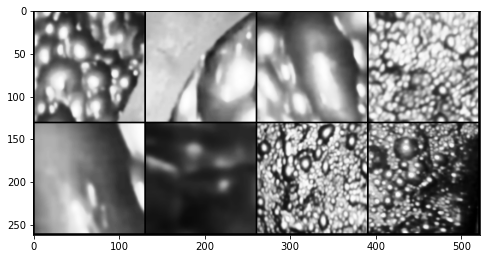

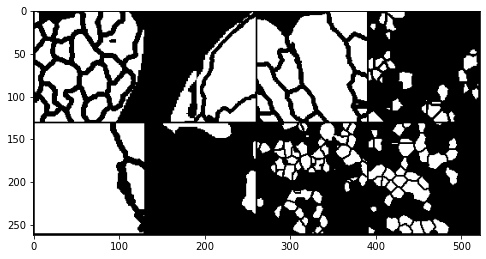

In [5]:
batch_img, batch_mask = iter(train_dataloader).next()

print(batch_img.shape, batch_mask.shape)
plot_samples_on_epoch(batch_img)
plot_samples_on_epoch(batch_mask.view(my_batch,1,main_size,main_size).expand_as(batch_img))

torch.cuda.empty_cache()